# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 01.12.2022

Мягкий дедлайн: 23:59MSK 11.12.2022

Жесткий дедлайн: 23:59MSK 15.12.2022

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
from sklearn.datasets import load_boston

In [4]:
boston = load_boston()

/Users/kirillkorolev/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the Californ

In [5]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.90937830610674

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [7]:
from tqdm.notebook import tqdm

In [8]:
def compute_biase_variance(regressor, X, y, num_runs=1000, tqdm_desc=''):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    # среднее предсказание для каждого объекта, который попадал в out-of-bag выборку
    # нужно для подсчета смещения
    avg_pred = np.zeros(len(y), dtype=float)
    
    # среднее квадратов предсказаний для каждого объекта, который попадал в out-of-bag выборку
    # нужно для подсчета разброса
    avg_squared_pred = np.zeros(len(y), dtype=float)
    
    # количество раз, которое каждый объект попадал в out-of-bag выборки
    num_hits = np.zeros(len(y), dtype=int)
    
    error = 0.0
    
    for i in tqdm(range(num_runs), desc=tqdm_desc):
        boot_indices = np.random.choice(np.arange(len(X)), size=len(X))
        boot_mask = np.zeros(len(X), dtype=bool)
        boot_mask[boot_indices] = True
        
        # бутстрап выборки, на них обучаемся
        X_boot, y_boot = X[boot_mask], y[boot_mask]
        
        # out-of-bag, на них тестируем
        X_out, y_out = X[~boot_mask], y[~boot_mask]

        regressor.fit(X_boot, y_boot)
        y_pred = regressor.predict(X_out)
        
        avg_pred[~boot_mask] += y_pred
        avg_squared_pred[~boot_mask] += (y_pred**2)
        num_hits[~boot_mask] += 1
        
        error += ((y_pred - y_out)**2).sum()
    
    # усредняем все ошибки
    error /= num_hits.sum()
    
    # усредняем предсказания
    avg_pred /= np.maximum(1, num_hits)
    avg_squared_pred /= np.maximum(1, num_hits)
    
    # учитываем только те объекты, которые попали в out-of-bag хотя бы 1 раз
    obj_mask = num_hits > 0
    
    # считаем смещение для объекта как отклонение среднего предсказания от истинного ответа, усредняем по объектам
    bias = ((avg_pred[obj_mask] - y[obj_mask])**2).mean()
    
    # считаем разброса для объекта как выборочную дисперсию, усредняем по объектам
    variance = (avg_squared_pred[obj_mask] - (avg_pred[obj_mask]**2)).mean()
    
    return bias, variance, error
    

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [10]:
### your code here
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [57]:
bvd_df = pd.DataFrame(columns=['bias', 'variance', 'error'])

bvd_df.loc['linreg', :] = compute_biase_variance(LinearRegression(), X, y, tqdm_desc='lingreg')
bvd_df.loc['decision_tree', :] = compute_biase_variance(DecisionTreeRegressor(), X, y, tqdm_desc='decision_tree')
bvd_df.loc['random_forest', :] = compute_biase_variance(RandomForestRegressor(), X, y, tqdm_desc='random_forest')

bvd_df

lingreg:   0%|          | 0/1000 [00:00<?, ?it/s]

decision_tree:   0%|          | 0/1000 [00:00<?, ?it/s]

random_forest:   0%|          | 0/1000 [00:00<?, ?it/s]

,bias,variance,error
lingreg,23.7267,0.583917,24.3206
decision_tree,10.7555,12.5941,23.3458
random_forest,11.0731,1.45359,12.539


Sanity-check. Разница между смещением+разбросом и ошибкой.

In [74]:
bvd_df.apply(lambda x: np.abs(x[2] - x[0] - x[1]), axis=1).to_numpy()

array([0.00997751, 0.00370721, 0.01239739])

__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ Линейная регрессия: модель довольно простая и не выразительная, поэтому у нее большой разброс, однако она менее склона к переобучению и подстраиванию под данные из-за своей простоты, поэтому разброс низкий.

Решающие деревья: можно добиться нулевого смещения, если использовать глубокие деревья, по сути запоминая обущающую выборку, однако по умолчанию мы как-то ограничили глубину, поэтому смещение хоть и меньше, чем у линейной регрессии, но не нулевое. Соответственно деревья больше склонны к переобучению по той же причине. Увеличивая глубину дерева или изменяя другие гиперпараметры, будет уменьшаться смещение и увеличиваться разброс

Случайный лес: мы хотим ансамблироваровать деревья - бэггинг над деревьями. Знаем, что для бэггинга смещение остается как у базовой модели, а разброс уменьшается в n раз, если модели некоррелированны. Видим такую же картину и в табличке: смещение примерно такое же, а разброс сильно уменьшился.

В целом практика соответствует теории.

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__ Посмотрим на табличку ниже.

Бэггинг оставляет смещение базовой модели и уменьшает в n раз разброс, если модели не коррелированны.

Линейная регрессия: смещение осталось, разброс даже увеличился, потому что линейные модели тяжелее сделать не коррелированными.
Деревья: теория подтвердилась, смещение как у базовой, а разброс уменьшился, так как внутри BaggingRegressor видимо используется деревья разной природы, ну в общем-то обучает на разных подмножествах, соответственно деревья разные довольно из-за своего построения.
Случайный лес: бэггинг над случайным лесом по сути и есть случайный лес. Так как бэггинг обучает базовые модели на подмножествах данных, а случайный лес тоже это делает. Мы видим, что результаты примерно одинаковые.

In [75]:
from sklearn.ensemble import BaggingRegressor

In [78]:
bvd_bagging_df = pd.DataFrame(columns=['bias', 'variance', 'error'])

bvd_bagging_df.loc['bagging_linreg', :] = compute_biase_variance(BaggingRegressor(LinearRegression(), random_state=42), X, y, tqdm_desc='bagging lingreg')
bvd_bagging_df.loc['bagging_decision_tree', :] = compute_biase_variance(BaggingRegressor(DecisionTreeRegressor(), random_state=42), X, y, tqdm_desc='bagging decision_tree')
bvd_bagging_df.loc['bagging_random_forest', :] = compute_biase_variance(BaggingRegressor(RandomForestRegressor(), random_state=42), X, y, tqdm_desc='bagging random_forest')

bvd_bagging_df

bagging lingreg:   0%|          | 0/1000 [00:00<?, ?it/s]

bagging decision_tree:   0%|          | 0/1000 [00:00<?, ?it/s]

bagging random_forest:   0%|          | 0/1000 [00:00<?, ?it/s]

,bias,variance,error
bagging_linreg,23.7701,0.784475,24.5659
bagging_decision_tree,10.975,2.65083,13.6258
bagging_random_forest,12.6416,0.855652,13.5152


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [159]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    test_indices = np.random.choice(np.arange(len(X)), size=num_test_objects, replace=False)
    test_mask = np.zeros(len(X), dtype=bool)
    test_mask[test_indices] = True
    
    X_test, y_test = X[test_mask], y[test_mask]
    X_train, y_train = X[~test_mask], y[~test_mask]
    
    preds = np.zeros((num_runs, num_test_objects), dtype=float)
    
    for i in tqdm(range(num_runs), desc=title):
        bootstrap_indices = np.random.choice(np.arange(len(X_train)), size=len(X_train))
        regressor.fit(X_train[bootstrap_indices], y_train[bootstrap_indices])
        y_pred = regressor.predict(X_test)
        preds[i, :] = y_pred
    
    plt.scatter(np.array(list(np.arange(num_test_objects)) * num_runs), preds.ravel(), s=2, c='blue')
    plt.scatter(list(np.arange(num_test_objects)), y_test, s=10, c='black')
    plt.ylim(0, 55)
    plt.xlabel('Номер объекта')
    plt.ylabel('Предсказание')
    plt.title(title)

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

Линейная регрессия:   0%|          | 0/100 [00:00<?, ?it/s]

Решающее дерево:   0%|          | 0/100 [00:00<?, ?it/s]

Случайный лес:   0%|          | 0/100 [00:00<?, ?it/s]

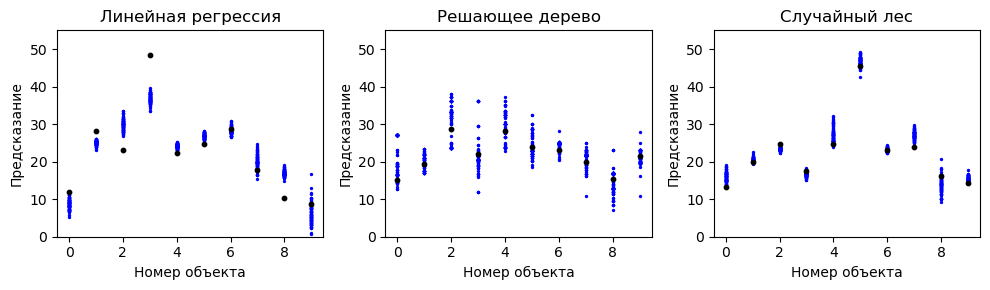

In [161]:
### your code here
plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)
plot_predictions(LinearRegression(), X, y, title='Линейная регрессия')

plt.subplot(1, 3, 2)
plot_predictions(DecisionTreeRegressor(), X, y, title='Решающее дерево')

plt.subplot(1, 3, 3)
plot_predictions(RandomForestRegressor(), X, y, title='Случайный лес')

plt.tight_layout()
plt.show()

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ Опять повторяем мантру про то, что для линейной регрессии видим, что предсказания отличаются от трушного, что характеризует высокое смещение, разброс такой не особо большой. Для деревьев предсказания около истинного, но разброс большой. Лес исправляет эти проблемы, и предсказываем хорошо и разброс низкий.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [173]:
import seaborn as sns

In [198]:
### your code here
biases = []
variances = []

max_depth_range = np.arange(1, 11)

for max_depth in max_depth_range:
    bias, variance, error = compute_biase_variance(DecisionTreeRegressor(max_depth=max_depth), X, y)
    biases += [bias]
    variances += [variance]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

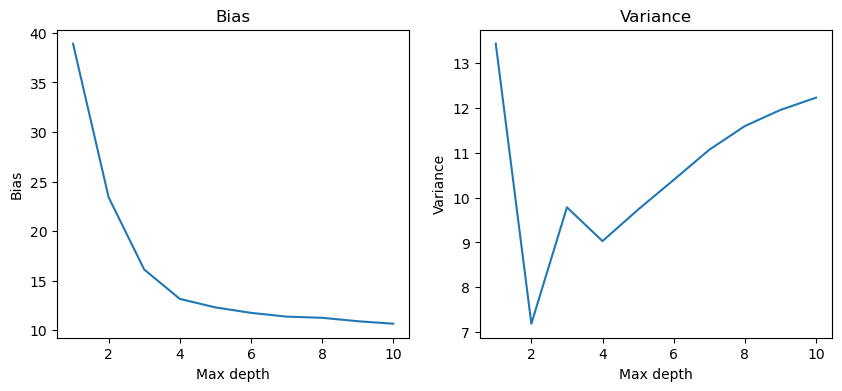

In [199]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(list(max_depth_range), biases);
plt.xlabel('Max depth')
plt.ylabel('Bias')
plt.title('Bias')


plt.subplot(1, 2, 2)
plt.plot(list(max_depth_range), variances);
plt.xlabel('Max depth')
plt.ylabel('Variance')
plt.title('Variance')

plt.show()

Естественным образом при увеличении глубины смещение уменьшается. Разброс тоже растет от глубины, как говорит нам теория.

In [202]:
biases = []
variances = []

max_features_range = range(1, X.shape[1] + 1)

for max_features in max_features_range:
    bias, variance, error = compute_biase_variance(DecisionTreeRegressor(max_features=max_features), X, y)
    biases += [bias]
    variances += [variance]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

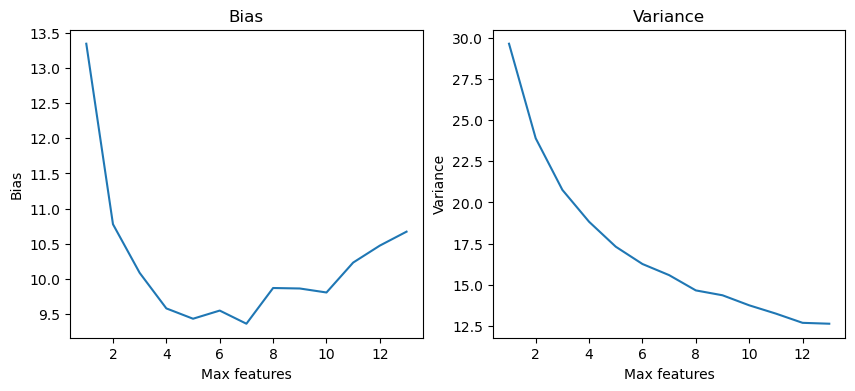

In [203]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(list(max_features_range), biases);
plt.xlabel('Max features')
plt.ylabel('Bias')
plt.title('Bias')


plt.subplot(1, 2, 2)
plt.plot(list(max_features_range), variances);
plt.xlabel('Max features')
plt.ylabel('Variance')
plt.title('Variance')

plt.show()

При увеличении максимального количества признаков дерево становится более разнообразным и имеет большую выразительность, следовательно меньше переобучается. Но видимо некоторые признаки шумовые и поэтому при увеличении max features смещение может даже увеличиться.

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [12]:
### your code here
biases = []
variances = []

n_estimators_range = 2**np.arange(1, 10)

for n_estimators in tqdm(n_estimators_range):
    bias, variance, error = compute_biase_variance(RandomForestRegressor(n_estimators=n_estimators), X, y)
    biases += [bias]
    variances += [variance]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

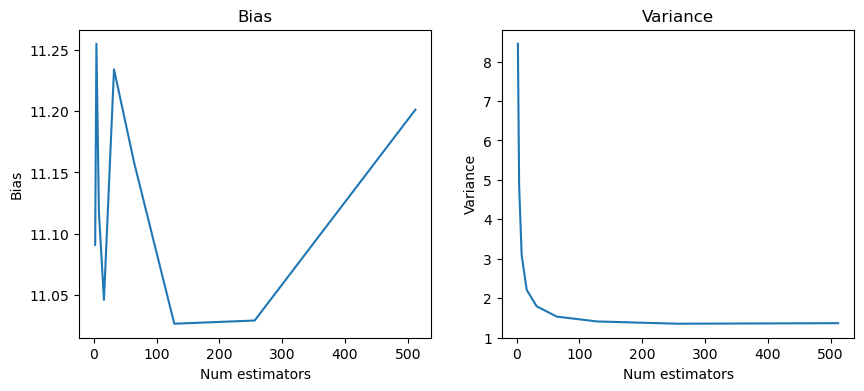

In [13]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(list(n_estimators_range), biases);
plt.xlabel('Num estimators')
plt.ylabel('Bias')
plt.title('Bias')


plt.subplot(1, 2, 2)
plt.plot(list(n_estimators_range), variances);
plt.xlabel('Num estimators')
plt.ylabel('Variance')
plt.title('Variance')

plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__ Для случайного леса количество базовых моделей обратно пропорционально разбросу, что теоретически подтверждается. Смещение несколько случайное, должно быть +- константное по теории.

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

In [15]:
biases = []
variances = []

n_estimators_range = 2**np.arange(1, 10)

for n_estimators in tqdm(n_estimators_range):
    bias, variance, error = compute_biase_variance(GradientBoostingRegressor(n_estimators=n_estimators), X, y)
    biases += [bias]
    variances += [variance]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

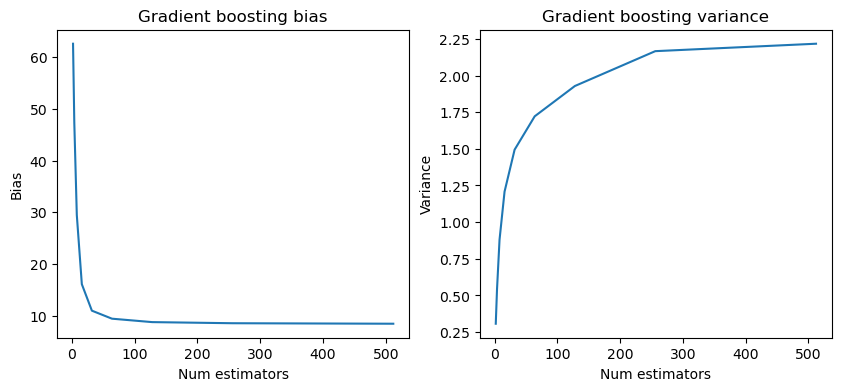

In [16]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(list(n_estimators_range), biases);
plt.xlabel('Num estimators')
plt.ylabel('Bias')
plt.title('Gradient boosting bias')


plt.subplot(1, 2, 2)
plt.plot(list(n_estimators_range), variances);
plt.xlabel('Num estimators')
plt.ylabel('Variance')
plt.title('Gradient boosting variance')

plt.show()

Теория говорит, что в градиентном бустинге добавляя новую модель пытаемся уменьшить ошибку, поэтому смещение будет только уменьшаться, а модель становится сложнее, поэтому она и переобучится, что мы и видим справа.

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__

![](https://memepedia.ru/wp-content/uploads/2017/08/%D0%B7%D0%B0%D0%BC%D0%B5%D1%80%D0%B7%D1%88%D0%B8%D0%B9-%D0%B4%D0%B6%D0%B5%D0%BA-%D0%BD%D0%B8%D0%BA%D0%BE%D0%BB%D1%81%D0%BE%D0%BD.jpg)